In [1]:
import librosa as lb
import soundfile as sd
import random as rd
import numpy as np
import json as js
import os
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.text import Tokenizer
from librosa.feature.inverse import mel_to_stft
from librosa import griffinlim
from soundfile import write
from tocotron import Tocotron
from generators import TextMelGenerator

In [2]:
batch_size = 32
data_path = "c:\\Users\\1\\Desktop\\dev-clean"
generator = TextMelGenerator(data_path=data_path, batch_size=batch_size)

In [3]:
test_gen = next(generator)
test_gen["mel_sp"] = test_gen["mel_sp"][:, :50, :]

In [4]:
max_sum = 0
for sample in test_gen["mel_sp"]:

    curent_sum = np.sum(sample)
    if curent_sum > max_sum:

        need_sample = sample
        max_sum = curent_sum
    

In [5]:
audio = mel_to_stft(need_sample)
audio = griffinlim(audio)

In [6]:
audio_folder = "c:\\Users\\1\\Desktop\\audio_files"
audio_file = os.path.join(audio_folder, "0file.wav")
write(audio_file, data=audio, subtype='PCM_24', samplerate=14000)

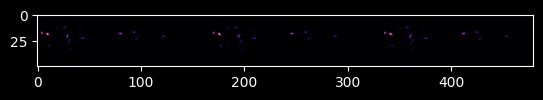

In [7]:
plt.style.use("dark_background")
fig, axis = plt.subplots()
axis.imshow(need_sample, cmap="inferno")
plt.show()

In [8]:
encoder_train_data = []
decoder_train_data = []
need_size = 1000

for (sample_n, sample) in enumerate(iter(generator)):

    if sample_n * batch_size > need_size:
        break

    encoder_train_data.append(sample["text"])
    decoder_train_data.append(sample["mel_sp"])



In [9]:
decoder_train_data = np.concatenate(decoder_train_data, axis=0)
decoder_train_data = decoder_train_data[:, :50, :]
print(decoder_train_data.shape)


(1024, 50, 480)


In [10]:
tmp_encoder_data = encoder_train_data[0]
for text_sample in encoder_train_data[2:]:
    tmp_encoder_data += text_sample

encoder_train_data = tmp_encoder_data

In [11]:
need_len = max([len(text_sample.split()) for text_sample in encoder_train_data])
for (sample_n, text_sample) in enumerate(encoder_train_data):

    if need_len < len(text_sample.split()):
        prep_text_sample = text_sample[:need_len]
    
    elif need_len > len(text_sample.split()):
        
        add_list  = ["." for _ in range(len(text_sample) - need_len)]
        prep_text_sample = text_sample.split() + add_list
        prep_text_sample = " ".join(word for word in prep_text_sample)
    
    
    encoder_train_data[sample_n] = prep_text_sample

In [12]:
encoder_tokenizer = Tokenizer()
encoder_tokenizer.fit_on_texts(encoder_train_data)
encoder_train_data = encoder_tokenizer.texts_to_sequences(encoder_train_data)
max_len = max([len(text_sample) for text_sample in encoder_train_data])

In [13]:
for (sample_n, token_sample) in enumerate(encoder_train_data):

    if max_len > len(token_sample):

        add_list = [0 for _ in range(max_len - len(token_sample))]
        tmp_tokens = token_sample + add_list
        encoder_train_data[sample_n] = tmp_tokens

In [14]:
encoder_train_data = np.asarray(encoder_train_data, dtype="int")

In [15]:
params_json = {
    "run_folder": "c:\\Users\\1\\Desktop\\models_save\\Tacotron2",
    "encoder_params": {        
        "total_words_n":    len(encoder_tokenizer.word_index) + 1,
        "embedding_size":   100,
        "layers_n":         3,
        "units":            decoder_train_data.shape[2],
        "activation":       None,
        "dropout_rate":    0.34
    },

    "decoder_params": {
        "mel_record_len": 35,

        "linear_projection": {
            "activation": "linear",
            "dropout_rate": 0.56,
            "epsilon": 0.001
        },

        "prenet_params": {
            "epsilon": 0.001,
            "dropout_rate": 0.56
        },
        
        "filters":          [32, 32, 64, decoder_train_data.shape[2]    ],
        "kernel_size":      [5, 5, 5, 5                                 ],
        "padding":          ["same", "same", "same", "same"             ],
        "strides":          [1, 1, 1, 1                                 ],
        "dropout_rates":    [0.56, 0.56, 0.56, 0.66                     ],
        "activations":      ["tanh", "tanh", "tanh", "tanh"             ],
        "normalization_epsilon": 0.01
    }
}

In [16]:
tocotron_model = Tocotron(params_json=params_json)

In [17]:
print(tocotron_model.encoder.summary())

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, None, 100)      │       380,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, None, 480)      │     1,115,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, None, 480)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, None, 480)      │     1,845,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, None, 480)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, None, 480)      │     1,845,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, None, 480)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,186,060 (19.78 MB)

 Trainable params: 5,186,060 (19.78 MB)

 Non-trainable params: 0 (0.00 B)

None


In [18]:
print(tocotron_model.decoder.summary())

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, None, 480) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, None, 480) │        960 │ input_layer_1[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ (None, None, 480) │  1,845,120 │ sequential[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, None, 480) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, None, 32)  │     76,832 │ sequential[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, None, 480) │          0 │ lstm_3[0][0],     │
│ (Attention)         │                   │            │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, None, 512) │          0 │ conv1d[0][0],     │
│ (Concatenate)       │                   │            │ attention[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, None, 32)  │     81,952 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, None, 32)  │         64 │ conv1d_1[0][0]    │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, None, 32)  │      5,152 │ sequential_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_2        │ (None, None, 32)  │         64 │ conv1d_2[0][0]    │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, None, 64)  │     10,304 │ sequential_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_3        │ (None, None, 64)  │        128 │ conv1d_3[0][0]    │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, None, 480) │    154,080 │ sequential_3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_4        │ (None, None, 480) │        960 │ conv1d_4[0][0]    │
│ (Sequential)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,175,616 (8.30 MB)

 Trainable params: 2,175,616 (8.30 MB)

 Non-trainable params: 0 (0.00 B)

None


In [19]:
encoder_out = tocotron_model.encoder.predict(encoder_train_data)

31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step


In [20]:
print(encoder_out.shape, decoder_train_data.shape)

(992, 69, 480) (1024, 50, 480)


In [21]:
decoder_train_data = decoder_train_data[:encoder_out.shape[0]]
decoder_out = tocotron_model.decoder.predict([decoder_train_data, encoder_out])

31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step


In [22]:
model_output = tocotron_model.model.predict([encoder_train_data, decoder_train_data])

31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 166ms/step


In [23]:
tocotron_model.train(encoder_train_data, decoder_train_data, epochs=10, batch_size=32, shuffle=True)

Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 39s 971ms/step - loss: 1031.7725
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 30s 977ms/step - loss: 1015.3301
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 31s 990ms/step - loss: 862.6013
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 30s 972ms/step - loss: 1090.7080
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - loss: 1073.3624
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - loss: 1016.5808
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - loss: 1122.5444
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - loss: 849.4744
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - loss: 1174.7150
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - loss: 1101.0715


In [24]:
encoder_preds = tocotron_model.encoder.predict(encoder_train_data)
decoder_preds = tocotron_model.decoder.predict([decoder_train_data, encoder_preds])

31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step


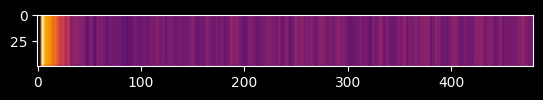

In [25]:
random_sample = decoder_preds[np.random.randint(0, 100)]
fig, axis = plt.subplots()
axis.imshow(random_sample, cmap="inferno")
plt.show()

In [26]:
samplrate=14000
audio = mel_to_stft(random_sample)
audio = griffinlim(audio)

In [27]:
audio_folder = "c:\\Users\\1\\Desktop\\audio_files"
audio_file = os.path.join(audio_folder, "0file.wav")
write(audio_file, data=audio, subtype='PCM_24', samplerate=samplrate)